In [6]:
import pylab as plt
import numpy as np
from cartopy import crs as ccrs
from netCDF4 import Dataset
import xarray as xr


import sys as sys
import pickle
import glob as glob
import datetime as dt

sys.path.append('../src/')
import swot_ssh_utils as swot
import swot_swell_utils as swell
from  lib_filters_obp import *


import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
from matplotlib.pyplot import cm
import cmocean
import cmocean.cm as cmo
lightcmap = cmocean.tools.lighten(cmo.ice, 1)

#PATH_with_functions = '/home/ardhuin/TOOLS/OPTOOLS/PYTHON/'
#sys.path.append(PATH_with_functions)
from  spectral_analysis_functions import *
from  wave_physics_functions import *
plt.rcParams.update({'font.size': 18,'savefig.facecolor':'white'})

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,10],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})
hemiNS=['A','N','S']
hemiWE=['A','E','W']

looking for files: ../data/SWOT_L?_LR_WIND_WAVE_007_026*v2.1_light.nc
reading L3 WIND WAVE file: ../data/SWOT_L3_LR_WIND_WAVE_007_026_20231124T073111_20231124T082154_v2.1_light.nc
indices of selected spectra: 548 0
lat,lon: -11.99482 218.66115
reading Unsmoothed file: /media/ardhuin/FabLinux/SWOT2/Unsmoothed/SWOT_L3_LR_SSH_Unsmoothed_007_026_20231124T073111_20231124T082154_v1.0.2.nc


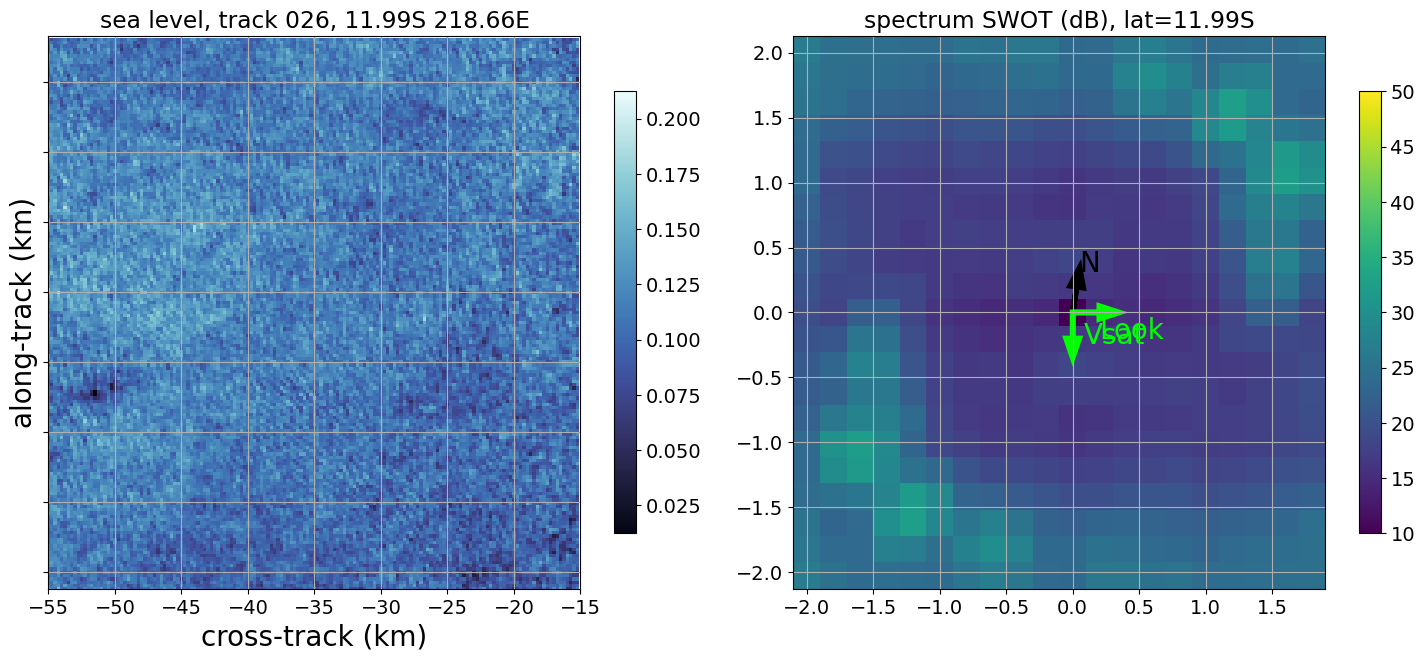

In [7]:
# Reading SWOT data


# folder is the location of the data files with one example of spectrum file including partition information 

# 1.a Example using LOPS-generated v2.1 file (contains a little more information than the CNES L3 v2): 
mypath='../data/'
folder=mypath;tag='v2.1_light_part' # folder for spectra, and choice of filename extension; v2.1_light is for the home-made spectra
#folder=mypath+'data/SWOT_data_by_storm/storm_Eddie_20241221T15/';tag='v2.1_light' # folder for spectra, and choice of filename extension; v2.1_light is for the home-made spectra
folder=mypath;tag='v2.1_light' # folder for spectra, and choice of filename extension; v2.0 is for the v2 data available on AVISO


# 1.b Example using CNES v2 file (Light and Extended): 
#folder='/media/ardhuin/FabLinux/SWOT_SPECTRA/Light/cycle_005/';tag='_v2.0'

#2. information for SSH from unsmoothed files
pth_swot='/media/ardhuin/FabLinux/SWOT2/Unsmoothed/'                       # folder for surface elevation maps (downloaded from ftp-access.aviso.altimetry.fr )


# choice of SWOT cycle and track and choice of spectrum location along track 
cycle='005';tracks='328';ibox=730 
#cycle='005';tracks='328';ibox=750 

cycle='548';tracks='017';ibox=296 
#cycle='548';tracks='017';ibox=293 
#cycle='547';tracks='021';ibox=240 
#cycle='547';tracks='021';ibox=210 

#cycle='005';tracks='082';ibox=600

cycle='026';tracks='281';ibox=194 
cycle='026';tracks='266';ibox=710 
cycle='026';tracks='214';ibox=816 
cycle='007';tracks='026';ibox=548 

print('looking for files:',folder+'SWOT_L?_LR_WIND_WAVE_'+cycle+'_'+tracks+'*'+tag+'.nc' ) 
file_listnc = sorted(glob.glob(folder+'SWOT_L?_LR_WIND_WAVE_'+cycle+'_'+tracks+'*'+tag+'.nc'));

ntrack=int(tracks)
sflip=np.mod(ntrack,2)
print('reading L3 WIND WAVE file:',file_listnc[0])
#L3Snc=xr.open_dataset(file_listnc[0],decode_times=False)
L3Snc=xr.open_dataset(file_listnc[0])

indx=np.mod(ibox,2)
print('indices of selected spectra:',ibox,indx) #, ', partition height (m):', L3Snc.Hpart[ibox].values)

la2=L3Snc['latitude'][ibox].values
lo2=L3Snc['longitude'][ibox].values

print('lat,lon:',la2,lo2)

angt=L3Snc['track_angle'][ibox].values
now=L3Snc.time[ibox].values

kx2=L3Snc['fx2D'].values
ky2=L3Snc['fy2D'].values

E_SWOT=L3Snc['Efxfy_SWOT'][ibox,:,:]
ambiguous=1
if 'ang_SWOT' in L3Snc:
    phase=L3Snc['ang_SWOT'][ibox,:,:]
    ambiguous = 0
else:
    #phase=E_SWOT*0+90+ky2/0.0001  : quick fix if we have no X-spectra phase
    ambiguous = 0
    new_filepath = file_listnc[0].replace('Light', 'Extended').replace('WIND_WAVE', 'WIND_WAVE_Extended')
    L3SncE=xr.open_dataset(new_filepath,group='tile_5km/box_40km')
    phase=L3SncE['ang_SWOT'][ibox,:,:]


fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(15,6.5))
plt.subplots_adjust(left=0.05,bottom=0.07, top=0.92,wspace=0.12,right=0.99)

ax=axs[1]
im=ax.pcolormesh(kx2*1000,ky2*1000,10*np.log10(E_SWOT),cmap='viridis',rasterized=True,vmin=10, vmax=50)
_=plt.colorbar(im,ax=axs[1],label='', location='right',shrink=0.8)
latcs=f'{abs(la2):3.2f}'+hemiNS[int(np.sign(la2))]
_=ax.set_title('spectrum SWOT (dB), lat='+latcs) #+f'{la2:03.1f}')
swell.arrows_on_spectrum(axs[1],1-sflip,indx,angt-180,color='k')

dkx=kx2[0,1]-kx2[0,0]
dky=ky2[1,0]-ky2[0,0]

ax=axs[0]

file_list = glob.glob(pth_swot+'SWOT_L3_LR_SSH_*Unsmoothed_'+cycle+'_'+tracks+'*.nc')
number_res=1; spectra_res='alpha'
dx,dy,indxc,ISHIFT,nkxr,nkyr,restab,nX2tab,nY2tab,mtab,ntab,indl,dind,samemask,hemiNS,hemiWE=swell.spec_settings_for_L3(number_res,spectra_res);
fs1=20
if (len(file_list) > 0) : 
# now gets the indices of the SSH map from the SWOT data (will only work with homemade spectra) 
   j1=L3Snc['boxindices'][ibox,0].values;j2=L3Snc['boxindices'][ibox,1].values  
   i1=L3Snc['boxindices'][ibox,2].values;i2=L3Snc['boxindices'][ibox,3].values
   file_swot=file_list[0]
   print('reading Unsmoothed file:',file_swot)

   tags=file_swot.split(sep='/')
   ddl = xr.open_dataset(file_swot)
   ssha = ddl.ssha_unedited
   lat = ddl.latitude.values
   lon = ddl.longitude.values
   ISHIFT=60
   dlat=lat[j2,indxc+ISHIFT]-lat[j1,indxc+ISHIFT]
   sig0 = ddl.sigma0 #sig0_karin_2
   flas = ddl.quality_flag # sig0_karin_2_qual
   [nline,npix]=np.shape(ssha)
   
   X=(np.arange(npix)-indxc)*dx/1000
   indsub0=0
   shifty=j1
   Y=(np.arange(nline)+indsub0-shifty)*dy/1000 # warning the along-track resolutionis not exactly 250 m, more like 235 m 

   Xmem=X;
   Ymem=Y;
   mybox,mybos,flbox,X,Y,sflip,signMTF,Look=swell.SWOTarray_flip_north_up(dlat, \
                                                         'right',ssha[j1:j2,i1:i2],flas[j1:j2,i1:i2],sig0[j1:j2,i1:i2],Xmem,Ymem)

   if Look==-1:
                   axs=np.roll(axs,1)
                   plt.setp(ax.get_yticklabels(), visible=False)
                   _=axs[1].set_ylabel('along-track (km)',fontsize=fs1)
   else:
                   plt.setp(ax.get_yticklabels(), visible=False)
   #                _=axs.set_ylabel('along-track (km)',fontsize=fs1)
  
   im2=ax.pcolormesh(X[i1:i2],Y[j1:j2],mybox,rasterized=True, cmap=lightcmap,vmin=-0.1+np.nanmedian(mybox),vmax=0.1+np.nanmedian(mybox))
   latc=ddl.latitude[j1+nY2tab[0],i1+nX2tab[0]].values    # WILL HAVE TO CHANGE THIS ... 
   latcs=f'{abs(latc):3.2f}'+hemiNS[int(np.sign(latc))]
   lonc=lon[j1+nY2tab[0],i1+nX2tab[0]]; 
   loncs=f'{abs(lonc):3.2f}'+hemiWE[int(np.sign(lonc))]
   _=ax.set_title('sea level, track '+tracks+', '+latcs+' '+loncs)
   _=ax.set_xlabel('cross-track (km)', fontsize=fs1)
   ax.set_xlim((X[i1],X[i2]))
   ax.set_ylim((Y[j1],Y[j2]))
   _=plt.colorbar(im2,ax=ax,label='', location='right',shrink=0.8)
  

fig.savefig('banana_split1.pdf')


partition heights: [0.07539663 0.10146971 0.10964527 0.01690028 0.07429456] [2 1 0 4 3]
partition heights: [283.07252983 286.82113296 251.3246642  395.33309151 199.07290149]


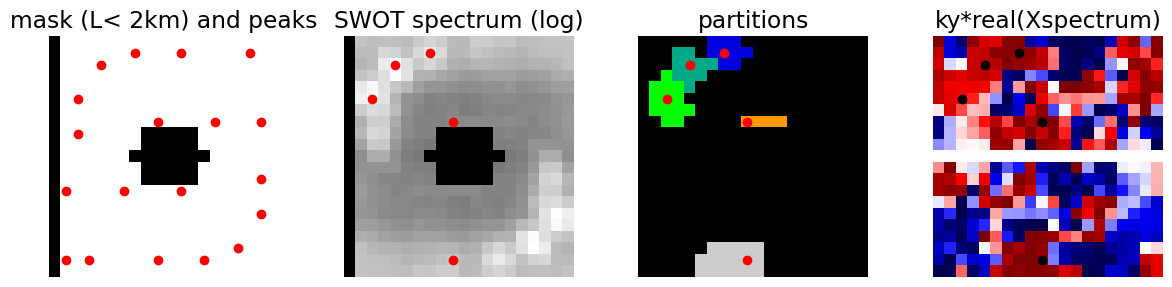

In [8]:
Ekth,kn1,theta1,E_SWOT_nonoise=swell.SWOT_denoise_isotropic(E_SWOT.values,kx2,ky2)


# computes partitions 
pmask,npeak2,coord2,image,labels,coords,signreal=swell.SWOT_partitions_watershed(kx2,ky2,angt,E_SWOT,phase,E_SWOT_nonoise,kmin=0.6,kmax=2.2)

# computes integrated parameters
Hs,Lmm1,LE,Lmp1,dm,sigth,Q18=swell.SWOTspec_to_HsLE(E_SWOT,kx2,ky2,pmask,E_SWOT*0+1+ambiguous,angt) 
sorted_indices = np.argsort(Hs)

print('partition heights:',Hs,sorted_indices[::-1])
print('partition heights:',Q18)
fig, axes = plt.subplots(ncols=4, figsize=(12, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].scatter(coords[:,1],coords[:,0],color='r')
ax[0].set_title('mask (L< 2km) and peaks')
ax[1].imshow(np.log10(E_SWOT)*image, cmap=plt.cm.gray)
#ax[1].imshow((E_SWOT)*image, cmap=plt.cm.gray)
ax[1].scatter(coord2[0:npeak2,1],coord2[0:npeak2,0],color='r')
ax[1].set_title('SWOT spectrum (log)')
ax[2].imshow(pmask, cmap=plt.cm.nipy_spectral)
ax[2].set_title('partitions')
ax[2].scatter(coord2[0:npeak2,1],coord2[0:npeak2,0],color='r')
ax[3].imshow(signreal, cmap=plt.cm.seismic,vmin=-1,vmax=1)
#ax[3].imshow(phase/180, cmap=plt.cm.seismic,vmin=-1,vmax=1)
ax[3].set_title('ky*real(Xspectrum)')
ax[3].scatter(coord2[:,1],coord2[:,0],color='k')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()